<a href="https://colab.research.google.com/github/Kavya-sree/Hair-Type-Classifier/blob/main/Hair_type_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import fastai
from fastai.vision.all import *

from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback


path = Path('D:\Hair-Type-Classifier\data')

In [11]:
#hair_types = 'curly','straight','wavy','kinky'


In [12]:
#fns = get_image_files(path)
#fns

## Data Loader
DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

In [13]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

With `DataBlock` API you can fully customize every stage of the creation of your `DataLoaders`.

In [14]:
hair_type = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))



# Define data augmentation transformations
batch_tfms = [
    RandomResizedCrop(224, min_scale=0.75),
    Flip(),
    Rotate(10),
    Zoom(1.1),
    Brightness(), Contrast(), Hue(), Saturation()
    ]

In [15]:
dls = hair_type.dataloaders(path, bs=64, batch_tfms=batch_tfms)

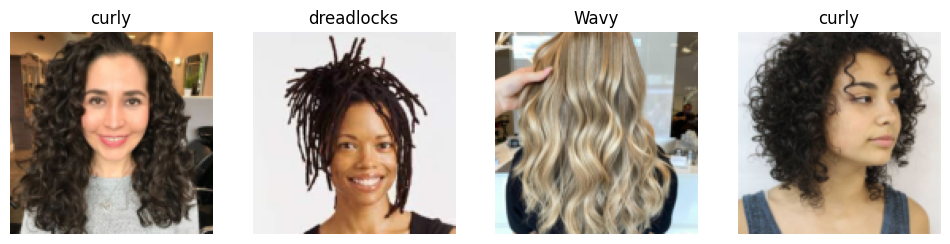

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

# Modelling

We don't have a lot of data for our problem, so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [17]:
hair = hair_type.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hair.dataloaders(path)

In [18]:
#learn = vision_learner(dls, resnet18, metrics=error_rate)
learn = vision_learner(dls, resnet18, metrics=error_rate, wd=1e-2, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2), SaveModelCallback(monitor='valid_loss')])

learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.761660,0.481812,0.178182,02:02


Better model found at epoch 0 with valid_loss value: 0.48181164264678955.


epoch,train_loss,valid_loss,error_rate,time
0,0.695481,0.383280,0.127273,01:51
1,0.568096,0.379086,0.112727,01:51
2,0.455294,0.391788,0.130909,01:50
3,0.376395,0.340870,0.098182,01:50
4,0.315874,0.323390,0.112727,01:50


Better model found at epoch 0 with valid_loss value: 0.3832797408103943.
Better model found at epoch 1 with valid_loss value: 0.3790859282016754.
Better model found at epoch 3 with valid_loss value: 0.3408695161342621.
Better model found at epoch 4 with valid_loss value: 0.3233899474143982.


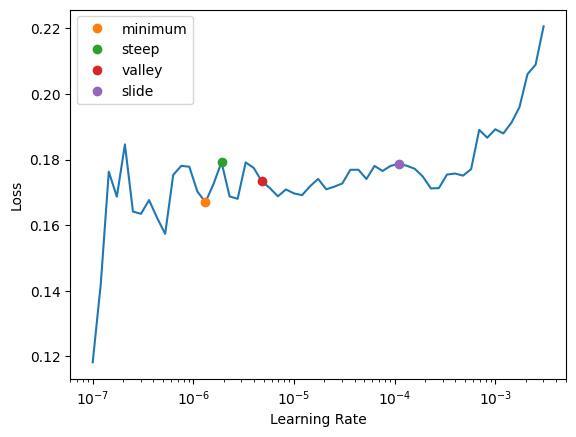

In [19]:
learn.save('stage-1')
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [20]:
learn.fit_one_cycle(10, lrs.valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.216172,0.329543,0.101818,01:42
1,0.191248,0.331265,0.094545,01:18
2,0.192007,0.327244,0.094545,01:19
3,0.192926,0.323347,0.101818,01:19
4,0.181213,0.319083,0.098182,01:19
5,0.178663,0.320553,0.090909,01:20
6,0.176036,0.318017,0.090909,01:20
7,0.174475,0.323992,0.090909,01:23
8,0.179529,0.323640,0.090909,01:22


Better model found at epoch 0 with valid_loss value: 0.3295425474643707.
Better model found at epoch 2 with valid_loss value: 0.3272436261177063.
Better model found at epoch 3 with valid_loss value: 0.3233472406864166.
Better model found at epoch 4 with valid_loss value: 0.31908348202705383.
Better model found at epoch 6 with valid_loss value: 0.31801682710647583.
No improvement since epoch 6: early stopping


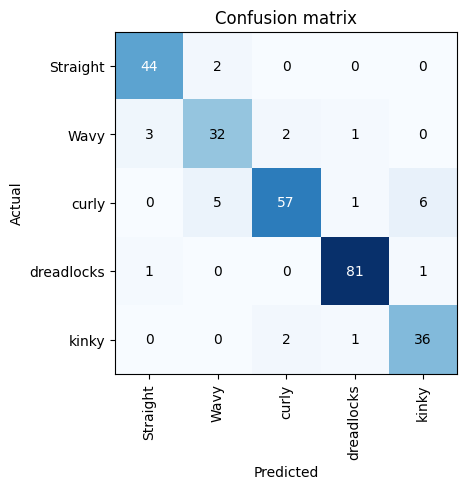

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

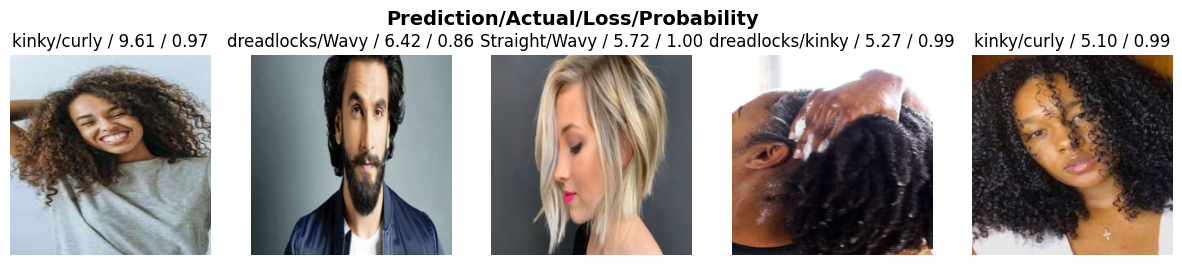

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
learn.export("models/hair-resnet18-model.pkl")